In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lib.utils import train_nn_model, sr_tuning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, r2_score, root_mean_squared_error
from pysr import PySRRegressor
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import re
import optuna

/home/hien/Work/AI/SDS-CP032-mlpaygrade/.venv/lib/python3.12/site-packages/juliacall/__init__.py:61: UserWarning: torch was imported before juliacall. This may cause a segfault. To avoid this, import juliacall before importing torch. For updates, see https://github.com/pytorch/pytorch/issues/78829.
  warnings.warn(


Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


In [2]:
cwd = Path.cwd()
source_data = Path(cwd)/"data"
output = Path(cwd)/"output"
preprocessed_data = cwd/'output/preprocessed_data'

# Loading Dataset

In [3]:
salaries = pd.read_parquet(preprocessed_data/'preprocessed_data.parquet')
salaries.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16494 entries, 0 to 16493
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   experience_level      16494 non-null  object 
 1   company_size          16494 non-null  object 
 2   work_year             16494 non-null  object 
 3   remote_ratio          16494 non-null  object 
 4   salary_currency       16494 non-null  object 
 5   employment_type       16494 non-null  object 
 6   job_type              16494 non-null  object 
 7   employee_continent    16494 non-null  object 
 8   company_continent     16494 non-null  object 
 9   job_level             16494 non-null  object 
 10  exp_level_job         16494 non-null  object 
 11  exp_level_econtinent  16494 non-null  object 
 12  job_level_exp         16494 non-null  object 
 13  work_year_econtinent  16494 non-null  object 
 14  kmeans_group          16494 non-null  object 
 15  same_continent     

In [4]:
X_train = np.load(preprocessed_data/'preprocessed_X_train.npy')
y_train = np.load(preprocessed_data/'preprocessed_y_train.npy')
X_test = np.load(preprocessed_data/'preprocessed_X_test.npy')
y_test = np.load(preprocessed_data/'preprocessed_y_test.npy')

In [5]:
features = pd.read_csv(preprocessed_data/'final_features.csv')
features

,Unnamed: 0,0
0,nom__employee_continent_North America,0.330858
1,nom__kmeans_group_4,0.121863
2,nom__salary_currency_USD,0.088748
3,ord__experience_level,0.064487
4,remainder__GDP_USD,0.044038
...,...,...
146,nom__salary_currency_CLP,0.000000
147,nom__salary_currency_ZAR,0.000000
148,nom__job_level_exp_Head_MI,0.000000
149,nom__salary_currency_NZD,0.000000


# Deep Learning

In [6]:
class ANNModel(nn.Module):
    def __init__(self, input_dim):
        super(ANNModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.dropout1 = nn.Dropout(0.2)
        self.fc2 = nn.Linear(128, 64)
        self.dropout2 = nn.Dropout(0.2)
        self.fc3 = nn.Linear(64, 32)
        self.dropout3 = nn.Dropout(0.2)
        self.fc4 = nn.Linear(32, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = F.relu(self.fc3(x))
        x = self.dropout3(x)
        x = self.fc4(x)
        return x

In [7]:
X_train_tensor = torch.from_numpy(X_train).float()
y_train_tensor = torch.from_numpy(y_train).float().unsqueeze(1)  # ensures shape (N, 1)
X_test_tensor = torch.from_numpy(X_test).float()
y_test_tensor = torch.from_numpy(y_test).float().unsqueeze(1)
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [8]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = ANNModel(input_dim=X_train.shape[1])
# criterion = nn.MSELoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001)

# train_losses, test_losses = train_nn_model(model, train_loader, test_loader,
#                                        criterion, optimizer, device, num_epochs=100)

# plt.plot(train_losses, label='Train Loss')
# plt.plot(test_losses, label='Test Loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()


# Symbolic Regression

In [ ]:
output_path = output/'pysr_outputs'

study, pysr_model, best_loss = sr_tuning(X_train, y_train, X_test, y_test, output_path)

print("Best hyperparameters:", study.best_params)
print("Best loss:", best_loss)


[I 2025-08-12 13:56:13,365] A new study created in memory with name: no-name-ed46a7c0-11a7-436e-b9a7-bf6050f41f9a
/home/hien/Work/AI/SDS-CP032-mlpaygrade/.venv/lib/python3.12/site-packages/pysr/sr.py:1469: UserWarning: Note: Using a large maxsize for the equation search will be exponentially slower and use significant memory.
  warnings.warn(
/home/hien/Work/AI/SDS-CP032-mlpaygrade/.venv/lib/python3.12/site-packages/pysr/sr.py:1873: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(
[I 2025-08-12 13:57:12,872] Trial 0 finished with value: 0.1425873060875096 and parameters: {'niterations': 192, 'population_size': 137, 'populations': 41, 'maxsize': 44, 'parsimony': 0.11292997086139955, 'ncycles_per_iteration': 642}. Best is trial 0 with value: 0.1425873060875096.


In [ ]:
symbolic_eq = pysr_model.get_best()
best_equation = pysr_model.sympy()
y_pred = pysr_model.predict(X_test)
print("Test MSE:", mean_squared_error(y_test, y_pred))
print("Test RMSE:", root_mean_squared_error(y_test, y_pred))
print("Test R2:", r2_score(y_test, y_pred))
print("Best equation:", best_equation)

Test MSE: 0.14244635720736357
Test RMSE: 0.3774206634610293
Test R2: 0.3628874136801372
Best equation: exp(x40 - sin(exp(-1.6295533*(x34 + (0.82019717 - x0)*(-0.06354967) + sin(exp(x141*(-x136 - 0.8541837)))) + (x34 + x83*(0.37787116 - x0) + 0.5470588)*(-3.4572165))) - 1*0.34629324) + 11.155542


In [ ]:
equation_str = str(best_equation)
# Find all 'xNN' occurrences, handling repeats
variable_indices = [int(x[1:]) for x in re.findall(r'x\d+', equation_str)]
unique_features = [features.iloc[idx, 0] for idx in sorted(set(variable_indices))]
unique_features

['nom__employee_continent_North America',
 'nom__kmeans_group_0',
 'nom__exp_level_job_MI_BI',
 'nom__work_year_econtinent_2023_Asia',
 'nom__kmeans_group_7',
 'nom__work_year_econtinent_2024_South America']

<Axes: xlabel='complexity'>

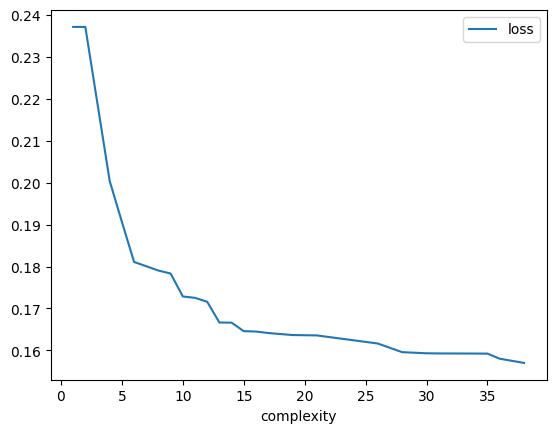

In [ ]:
sr_training_loss = pysr_model.equations_
sr_training_loss.plot(x="complexity", y="loss")